

# Capstone Project: Systematic Trading Strategies

## Goal: 
Implement a process of developing trading strategies in Indian Equity Markets using fundamental data of liquid listed companies that maximises out of sample average returns keeping risk under control.

## Who cares?

I do. I am planning to start my own investment firm. I have not focussed much on fundamental data before, neither have I explored advanced machine learning techniques to develop trading strategies. I specialize in analyzing short-term (seconds to minutes) movements in markets, not over months and years. If there indeed is value derived out of using some subset of Data Science that I learn during this course, I am happy to invest my own money on these trading strategies. Even otherwise, I believe making investment process data-driven and automated has benefits for everyone interested invest wisely and with minimum cost. 

## Data

I have subscribed to two data sets from Quandl.

1. [https://www.quandl.com/data/DEB-Core-India-Fundamentals-Data](https://www.quandl.com/data/DEB-Core-India-Fundamentals-Data) Contains fundamental indicators derived from company financials from published balance sheet, income statements and cash flow statements from roughly 4000 listed stocks on NSE or BSE.  History goes back to 2005
2. [https://www.quandl.com/data/TC1-Indian-Equities-Adjusted-End-of-Day-Prices](https://www.quandl.com/data/TC1-Indian-Equities-Adjusted-End-of-Day-Prices) Contains daily prices (open, low, high, close), volume and value traded for constituents of top 500 NSE listed stocks by market capitalization. The prices are adjusted from corporate actions like stock splits, rights issues, dividends, buy backs etc.

## Approach

We wish to follow the approach of a white paper published by a Deutsche Bank research group. In that paper the authors review various machine learning algorithms and apply them in practice on Japanese Equity markets data. The Following are the steps involved

1. **Data Selection** To decide the stock universe, date range for training set and test-set. Factors involved:
  * Data availability
  * Stock liquidity
  * Avoid any bias in universe selection like survivorship bias
2. ** Problem Formulation: ** 
Describe 
  * the context,
  * the feature space, 
  * the target variable, 
  * the optimization problem and 
  * the model selection metric and 
  * the evaluation criteria

2. **Investment signal creation and classification**: A close look at fundamental data set to see whether it needs enrichment i.e. computing well known indicators to make a comprehensive list of possible investment signals classified into various factors like growth, value, quality, size, momentum etc
3. **Visualize performance of individual investment signals ** If each investment signal is used only by itself as a ranker for long stock portfolio, how is the in-sample performance of the strategy. Steps involved:
    * Quintile portfolio construction function
    * A visualization tool to allow watching a large number of charts together

4. **Data pre-processing** like filling missing data, normalizing, uniformizing, sector-neutralizing, quantizing, winsorizing etc to make variations in output variable (returns) more sensitive to variations in input variables and also make combining variables more sensible.
5. **Create a benchmark** by using a simple linear model (with some basic checks) for other machine learning techniques to see if they do any better
6. **Test most promising models** as per the paper and see if they perform any better than the simple model
7. **Document the conclusions and insights**



## Data Selection 
To decide the date range for training set and test-set and stock universe for this study. Factors involved:

1. Data availability: 
    1. Fundamental Data-set is available 2005 onwards. 
    2. Adjusted Price data is available 2001 onwards. 
    3. Earnings release dates are available 2011 onwards. 
    4. There are more than 1000 stocks common in all the three data-sets
    5. ** Decisions: ** 
        1. Lets *not* throw away 2005-10 for absence of earnings release dates. Instead use it with a delay of 63 days from quarter end whenever earnings release dates are not available
        2. Training set: 2005 to 2011 
        3. Test set: 2012 - 2015 
        4. Reserved set (only for final reporting): 2016 - 2017 
2. Stock liquidity:
    1. Small cap stocks are known to be prone to manipulation (both of stock market and company fundamentals) 
    2. Trading in large amounts in smaller stocks will lead to heavy transaction costs. 
    3. ** Decision: ** Let us use top 200 stocks by market cap at each rebalance date. 
3. Avoid any bias in universe selection like survivorship:
    1. ** Decision: ** Instead of a fixed universe of stocks for entire period, let us use top 200 stocks by market cap, updated at every rebalance date. 



## Problem Formulation
### Context 
We are trying to create a robot to replace a portfolio manger. Or to at least save time of a human portfolio manager by automating strategy creation as much as possible. 

Typically, a long-short equity portfolio manager would identify stocks, using a combination of fundamental and technical analysis, that she believes would out-perform the benchmark (typically an index) and those that would under-perform the index in the long-term (typically 2-3 years). 

She would go long the former and short the latter to create delta-neutral long-short portfolio of stocks. She would periodically, typically every month or on special events like earnings releases, re-assess his portfolio in light of fresh information, and possibly "rebalance" i.e. change the weights of stock holdings in her portfolio slightly or at times dramatically. 

Her objective is to achieve great long-term returns. The clients would choose to invest in those funds whose fund-managers have a track-record of consistently providing great returns on their investment after taking away all costs and fees. Clients are usually also concerned about risk of price fluctuation in the short-term, and not just long-term returns. 

### Formulation

Lets say we are sitting at time $t$. We build our stock universe by using latest available market-cap information and choose top $N$ (say 200) stocks where both fundamental and price data are available. 

As of time $t$, we have information about company financials and stock price history for each of $N$ stocks in the form of a feature vector. These features are derived from the most recent earnings data released by each company. Examples of features are Price-to-earning-ratio, 3-year-compounded-annual-growth-rate-of-earnings etc.  We will add more features that are "technical" i.e. not related to company's financial health, but only related to its stock price movements. Lets say there are $F$ features. All features are stored in matrix $X_t$ of size $N$x$F$. Let's say we have a model, yet to be optimized, which ranks the $N$ stocks as a function of all their features from "best" to "worst". We go long (i.e. buy) the top 20% stocks, and short (i.e. borrow and sell) the bottom 20% stocks making an equally weighted long short portfolio. 

We move to time $t+1$, lets say, the time is measured in months (typical rebalance horizon for long-term fund). Let the stock price of $i$th stock see a return of $y_{t,i}$ from time $t$ to $t+1$. At $t+1$, we repeat the process by a fresh ranking of refreshed top $N$ market-cap stocks as a function of $X_{t+1}$ and then build another quintile portfolio based on it. We will *rebalance* our portfolio by buying and selling stocks such that at $t+1$, we hold the new top 20% as long and new bottom 20% as short. 

How does the model rank the $N$ stocks? By estimating $y_t$ at time $t$, which is unknown at time $t$ but known at time $t+1$. By using the benefit of hindsight, we can create a training set for our model that is aware of the values of $y_t$ at each time $t$. Various machine learning algorithms can then be applied predict $y_t$. We can use mean squared error in prediction of $y_t$ as the objective function to be minimized. 

To select the best model, we will not limit ourselves to using mean squared error in stock returns as a metric, but instead use out of sample performance of the quintile portfolio as our guiding light. Standard metrics of portfolio performance like Compounded Annual Rate of Returns (CAGR), Annualized Volatility (Vol), Sharpe Ratio, Information Ratio and Maximum Drawdown (MaxDD) etc will be computed along with a visual cumulative return chart to help us make a balanced decision about model selecton. 



In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set(style="ticks", color_codes=True)
plt.rcParams["figure.figsize"] = [15.0,6.0]

In [2]:
#load the fundamental set data or the feature set 
dfn = pd.read_pickle('fundamental_data_dfn.pkl')

#load the price data
prc = pd.read_csv('TC1\\TC1_20170717.csv', 
                 names = ['ticker','date','open','high','low','last','close','volume','valueTraded'],
                 header = None, parse_dates = ['date'])

In [38]:
#Perform Data selection as discussed in the "Data Selection" section above 
#And create target variable (forward returns) y as discussed in "Problem Formulation"

from earnings_dates import download_earnings_dates
from earnings_dates import guess_quarter_end_date

def createTrainingAndTestSet(dfn,prc,load=False):
    if load:
        print('Load = True, loading instead of generating X and y')
        X_train = pd.read_pickle('X_train.pkl')
        X_test = pd.read_pickle('X_test.pkl')
        y_train = pd.read_pickle('y_train.pkl')
        y_test = pd.read_pickle('y_test.pkl')
        return X_train,y_train, X_test,y_test
    
    ''' Create a training and test set '''
    trainStart = '2005-03-31';trainEnd = '2011-12-31';
    testStart = '2012-01-01' ; testEnd = '2015-12-31';
#    testEnd = '2017-07-31';

    rebalDays = 30 #Days after which to rebalance
    stockUniverseSize = 200 #top stocks by market cap will be chosen as our universe
    earningsReleaseDelay = 63 #days from quarter end we assume results will be public 
                              #important as we dont have earnings release dates before 2011
    horizon = 30   #days for which we are predicting the returns
    max_frac_nulls_returns = .05 #maximum fraction of null in returns of one ticker, beyond
                                #which we will drop the ticker from dataset
    max_look_back_days_mcap = 400 #Even if MCAP is released yearly, applying this filter will make
                                                  #we don't use extremely outdated MCAP for universe selection

    max_look_back_days_price = 5 #while fetching price for computing returns, we don't want to 
                                                  #compute returns on extremely outdated price. 
    
    #Get dates training and test
    trainDateIndex = pd.date_range(start=trainStart, end=trainEnd, freq=str(rebalDays)+'D')
    testDateIndex = pd.date_range(start=testStart, end=testEnd, freq=str(rebalDays)+'D')

    #We checked that MCAP is the same in standlone and consolidated in 24,442 and different
    #only in 60. 
    #Since consolidaed is null frequently, lets use standalone to define MCAP. 
    #dfn[(dfn.indicator == 'MCAP') & (~dfn.consolidated.isnull()) & ~(dfn.consolidated == dfn.standalone)].count()    

    #Create a dataframe sorted by date and then by market cap of tickers
    df_mcap = dfn[dfn.indicator == 'MCAP'].sort_values(['date','standalone'],ascending = (True,False))
    df_mcap = df_mcap[['date','ticker','standalone']]
    df_mcap.columns = ['QuarterEndDate','ticker','MCAP']

    #remove certain "crappy stocks" whose MCAP has serious errors identified painfully
    crappy_stocks = pd.read_csv('crappy_stocks.csv')
    crappy_stocks = crappy_stocks.ticker.tolist()
    df_mcap = df_mcap[~df_mcap.ticker.isin(crappy_stocks)]

    #sort prc data as per requirement of merge_asof
    prc = prc.sort_values(['date','ticker'])
   
    def createDFtopN(dateIndex,df_mcap,stockUniverseSize):
        '''Creates a DataFrame with cartesian product of all dates in dateIndex 
        and top stockUniverseSize market cap tickers'''
        all_tickers = df_mcap.ticker.unique()
        #Create the cartesian (cross) product of all dates and all tickers
        multiIndex = pd.MultiIndex.from_product([dateIndex,all_tickers],names = ['date','ticker'])
        X = pd.DataFrame(0,index=multiIndex,columns = ['temp'])
        X.reset_index(inplace=True)
        
        #In the cross product of all dates and all tickers, as of join the market caps
        X = pd.merge_asof(left=X,right=df_mcap,left_on='date',right_on='QuarterEndDate',by='ticker',
                          tolerance = pd.Timedelta(max_look_back_days_mcap,unit='D'))
        #There will be many null MCAPs because many stocks listed later and couldn't 
        #be filled by as of join in the cartesian product. Delete the nulls
        X = X.loc[X.MCAP.notnull(),['date','ticker','MCAP']]
        #For each date sort the tickers by descending market cap
        X = X.sort_values(['date','MCAP'],ascending = (True,False))
        #Now retain top stockUniverseSize and delete the rest
        X = X.groupby('date').apply(lambda x:x[0:stockUniverseSize])
        #Clean-up
        X = X.drop('date',1)
        X = X.reset_index()
        X = X.drop('level_1',1)

        #Check for bad data. Note this is not percentage but fractional change!
        X['pct_change_mcap'] = X.groupby('ticker')['MCAP'].pct_change()
        #We drop wherever market-cap more than 10 times in a quarter 
        #checked visually, such a change is more likely an error than real
        X = X[X.pct_change_mcap.abs() < 10]

        #Now let us prepare y, the target
        #use merge_asof with exact match allowed. So if price is found for that date, we take that, 
        #else we search backwards for the first available price. 
        y = pd.merge_asof(X[['date', 'ticker']],prc[['date', 'ticker', 'close']], on = 'date', by='ticker', 
                         tolerance = pd.Timedelta(max_look_back_days_price,unit='D'))
        y = y.rename(columns = {'date':'entry_date','close':'entry_price'})
        y['date'] = y.entry_date + pd.Timedelta(horizon, unit='D')
        #use merge_asof with exact match allowed. So if price is found for that date, we take that, 
        #else we search backwards for the first available price. 
        y = pd.merge_asof(y,prc[['date', 'ticker', 'close']], on = 'date', by='ticker',
                         tolerance = pd.Timedelta(max_look_back_days_price,unit='D'))
        y = y.rename(columns = {'date':'exit_date','close':'exit_price'})
        #y = y.sort_values(['ticker','date'])
        #y['return_1m'] = y.groupby('ticker')['close'].pct_change()
        y['return'] = (y.exit_price - y.entry_price)/y.entry_price
        y = y.rename(columns = {'entry_date':'date'})

        #Drop those tickers who have more than 5% (max_frac_nulls_returns) nulls in returns
        tickers_frac_nulls = y.groupby('ticker').apply(lambda x: np.sum(x.isnull())/len(x) )['return']
        tickers_to_retain = tickers_frac_nulls[tickers_frac_nulls < max_frac_nulls_returns].index.tolist()
        X = X[X.ticker.isin(tickers_to_retain)]
        y = y[y.ticker.isin(tickers_to_retain)]
        
        y.set_index(['date','ticker'])
#        X.set_index(['date','ticker','feature'])
        return X,y
    
    def add_features(X,dfn,earnings_dates,earningsReleaseDelay):

        #Populate BoardMeetingDate by matching guessed QuarterEndDate in earnings_dates
        #with date in dfn for each ticker
        dfn = pd.merge(dfn,earnings_dates[['QuarterEndDate','BoardMeetingDate','ticker','Purpose']],
                              left_on=['date','ticker'], right_on=['QuarterEndDate','ticker'],how ='outer')
#        set_trace()
        #we know that many (certainly before 2010) earnings dates are missing
        #so populate a new column with a default date created by adding a delay
        dfn['EarningsReleaseDate'] = dfn['date'] + pd.Timedelta(earningsReleaseDelay, unit='D')

        #Now overwrite this column with correct dates wherever available. 
        dfn.loc[dfn.BoardMeetingDate.notnull(),['EarningsReleaseDate']] = dfn.BoardMeetingDate[dfn.BoardMeetingDate.notnull()]

        #rename indicator to feature 
        dfn = dfn.rename(columns={'indicator':'feature'})

        #sort by earnings release date as to prepare of as-of-join
        dfn = dfn.sort_values(['EarningsReleaseDate','ticker','feature'])

        #create a place holder for all dates, tickers and features
        all_features = dfn.feature.unique()
        X['dummy'] = 0 #trick to effect cross product
        df_all_features =  pd.DataFrame(all_features, columns = ['feature'])
        df_all_features['dummy'] = 0 #trick to effect cross product
        #gets the cartesian product
        X_big = pd.merge(X,df_all_features,on='dummy')

        #In the cross product of rebalance dates, top 200 tickers, all features, 
        #as of join 'standalone' and 'consolidated' values
        #We have chosesn allow_exact_matches=False because earnings releases are
        #usually after market close. So the earliest we can act on that information is 
        #on the next day
        X_big_filled = pd.merge_asof(left=X_big,right=dfn,left_on='date',
                                     right_on='EarningsReleaseDate',by=['ticker','feature'],
                                    allow_exact_matches=False)

        #remove null rows and useless columns 
        X_big_filled = X_big_filled.loc[X_big_filled.freq.notnull(),['date_x','EarningsReleaseDate','QuarterEndDate','ticker','feature','standalone','consolidated']]
        X_big_filled = X_big_filled.rename(columns={'date_x':'date'})
        return X_big_filled

    #Create train and test dataframes of rows rebalDates x stockUniverseSize
    X_train,y_train = createDFtopN(trainDateIndex,df_mcap,stockUniverseSize)
    X_test,y_test = createDFtopN(testDateIndex,df_mcap,stockUniverseSize)

    #Get earnings release dates (downloaded from NSE for 2011 onwards for 1000+ stocks) 
    earnings_dates = download_earnings_dates('sending any input') 
    earnings_dates = guess_quarter_end_date(earnings_dates)
    
    #Create rebalance dates x top stockUniverseSize x available features and their values
    #(earnings release dates are required to avoid forward looking)
    X_train = add_features(X_train,dfn,earnings_dates,earningsReleaseDelay)
    X_test = add_features(X_test,dfn,earnings_dates,earningsReleaseDelay)
    if not load:
        print('load=False, saving X_train,y_train, X_test,y_test on disk')
        X_train.to_pickle('X_train.pkl')
        X_test.to_pickle('X_test.pkl')
        y_train.to_pickle('y_train.pkl')
        y_test.to_pickle('y_test.pkl')
    return X_train,y_train, X_test,y_test


In [39]:
%%time
#Call the function defined above to get training and test sets
X_train,y_train, X_test,y_test = createTrainingAndTestSet(dfn,prc,True)

Load = True, loading instead of generating X and y
Wall time: 547 ms


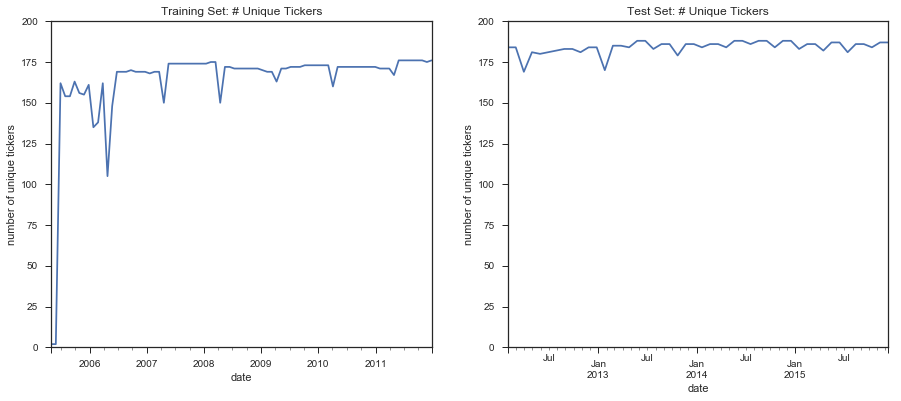

In [40]:
plt.subplot(1,2,1)
X_train.groupby('date')['ticker'].apply(lambda x: x.unique().shape[0]).plot()
plt.title('Training Set: # Unique Tickers');plt.ylim([0,200]);plt.ylabel('number of unique tickers')
plt.subplot(1,2,2)
X_test.groupby('date')['ticker'].apply(lambda x: x.unique().shape[0]).plot()
plt.title('Test Set: # Unique Tickers');plt.ylabel('number of unique tickers');plt.ylim([0,200]);

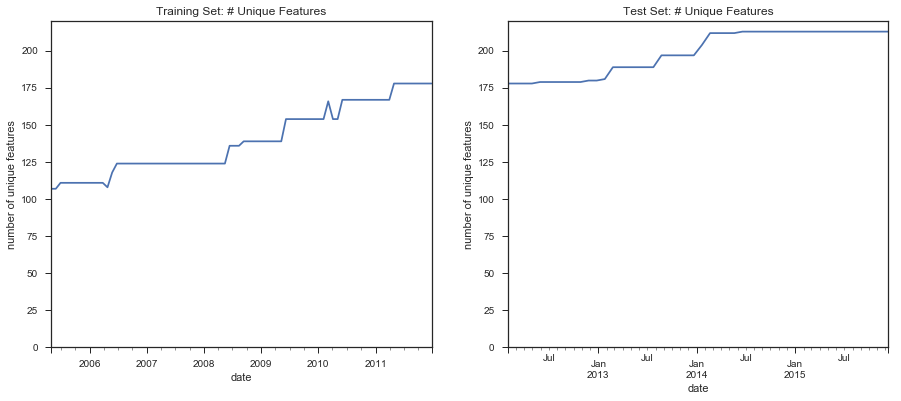

In [41]:
plt.subplot(1,2,1)
X_train.groupby('date')['feature'].apply(lambda x: x.unique().shape[0]).plot()
plt.title('Training Set: # Unique Features');plt.ylim([0,220]);plt.ylabel('number of unique features')
plt.subplot(1,2,2)
X_test.groupby('date')['feature'].apply(lambda x: x.unique().shape[0]).plot();
plt.title('Test Set: # Unique Features');plt.ylabel('number of unique features');plt.ylim([0,220]);

## Investment signal creation and classification: 
A close look at fundamental data set to see whether it needs enrichment i.e. computing well known indicators to make a comprehensive list of possible investment signals classified into various factors like growth, value, quality, size, momentum etc

In [56]:
#This description was available in the original data source 
solvency = pd.read_excel('DEB_Fundamental_Indicators.xlsx',sheetname='Solvency and Fundamentals')
valuation = pd.read_excel('DEB_Fundamental_Indicators.xlsx',sheetname='Risk, Pricing and Valuation')
profitability = pd.read_excel('DEB_Fundamental_Indicators.xlsx',sheetname='Profitability and Management')
earnings_growth = pd.read_excel('DEB_Fundamental_Indicators.xlsx',sheetname='Income Statement')
cashflow_growth = pd.read_excel('DEB_Fundamental_Indicators.xlsx',sheetname='Cash Flow Statement')
balance_sheet = pd.read_excel('DEB_Fundamental_Indicators.xlsx',sheetname='Balance Sheet')


In [62]:
solvency['category'] = 'solvency'
valuation['category'] = 'valuation'
profitability['category'] = 'profitability'
earnings_growth['category'] = 'earnings_growth'
cashflow_growth['category'] = 'cashflow_growth'
balance_sheet['category'] = 'balance_sheet'
feature_desription = pd.concat([solvency,valuation,profitability,earnings_growth,
                                cashflow_growth,balance_sheet])

In [63]:
#show 3 features from each category
feature_desription.groupby('category').apply(lambda x:x[-4:-1]).drop('category',1).reset_index().drop('level_1',1)

,category,feature,name,freq,priorImportance
0,balance_sheet,BVSH1,1 Year CAGR Growth in Book Value per Share,Annual,1
1,balance_sheet,BVSH3,3 Year CAGR Growth in Book Value per Share,Annual,1
2,balance_sheet,BVSH5,5 Year CAGR Growth in Book Value per Share,Annual,1
3,cashflow_growth,OPCF5,5 Year CAGR Growth in Operating Cashflow,Annual,2
4,cashflow_growth,CEPS1,1 Year CAGR Growth in Cash EPS per Share,Annual,2
5,cashflow_growth,CEPS3,3 Year CAGR Growth in Cash EPS per Share,Annual,2
6,earnings_growth,EPS1Q,1 Quarter Growth in EPS,Quarterly,2
7,earnings_growth,EPS4Q,4 Quarter Growth in EPS,Quarterly,2
8,earnings_growth,EPS8Q,8 Quarter Growth in EPS,Quarterly,2
9,profitability,CASHTO,Cash Turnover,Annual,1


 `priorImportance` is a column I have added in `feature_description` by using my knowledge of finance 
* `priorImportance = 0`:   feature not directly related to growth in stock price
* `priorImportance = 1`:   not the best, but feature maybe related to growth in stock price
* `priorImportance = 2`:   feature directly related to growth in stock price, commonly used as such

## Visualize performance of individual investment signals 
If each investment signal is used only by itself as a ranker for long stock portfolio, how is the in-sample performance of the strategy.


In [134]:
def get_quintile_portfolios_for_each_feature(X,y,feature_description,priorImportance=2):
    ''' Computes cumulative returns when stocks are ranked by values of each feature separately.
    Returns a matrix of cumulative returns of six kinds of portfolios (six columns) 'top',
    'second','middle', 'fourth','bottom' and 'longshort'. 
    
    First five stand for long-only portfolios of top 20%tile to bottom 20%tile respectively.
    The last one stands for long-short portfolio of long top 20% and short bottom 20% 
    Quintile portfolios of different features are merged one below the other. Seventh 
    column 'feature' identifies the block of matrix by name of the feature.''' 
    #important features are those that are available and of priorImportance
    important_features = pd.DataFrame(X.feature.unique(),columns = ['feature']).merge(feature_desription, how = 'inner')
    important_features = important_features[important_features.priorImportance == priorImportance]
    important_features = important_features.reset_index()

    portfolios = pd.DataFrame([]);
    for i in range(len(important_features)):        
        ranker = X[X.feature == important_features.feature[i]].copy()
        #Lets use consolidated where available else standalone
        ranker['ranker'] = np.where(ranker['consolidated'].isnull(),ranker['standalone'],ranker['consolidated'])
        ranker = ranker[['date','ticker','ranker']]
        portfolio = quintile_portfolios(y,ranker)
        portfolio['feature'] = important_features.feature[i]
        portfolios = pd.concat([portfolios, portfolio])
#        print('Feature %d of %d named %s done' % (i+1,len(important_features),important_features.feature[i]))
    return portfolios    

def quintile_portfolios(y,ranker):
    min_values_in_ranker = 25
    y = pd.merge(y,ranker, how='left')
    ranker_values_by_date = y.groupby('date')['ranker'].count()
    dates_with_very_few_rankers = ranker_values_by_date[ranker_values_by_date < min_values_in_ranker].index
    y = y[~y.date.isin(dates_with_very_few_rankers)]
    port = pd.DataFrame(np.full(([len(y.date.unique()),6]),np.nan), 
                              columns = ['top','second','middle','fourth','bottom','longshort'],index=y.date.unique())
    for date,dy in y.groupby('date'):
        q = np.nanpercentile(dy.ranker,[20,40,60,80])
        port.loc[date,['top']]    = dy.loc[(dy.ranker > q[3]),['return']].mean().values
        port.loc[date,['second']] = dy.loc[(dy.ranker > q[2]) & (dy.ranker <= q[3]),['return']].mean().values
        port.loc[date,['middle']] = dy.loc[(dy.ranker > q[1]) & (dy.ranker <= q[2]),['return']].mean().values
        port.loc[date,['fourth']] = dy.loc[(dy.ranker > q[0]) & (dy.ranker <= q[1]),['return']].mean().values
        port.loc[date,['bottom']] = dy.loc[(dy.ranker < q[0]),['return']].mean().values
        port.loc[date,['longshort']] = port.loc[date,['top']].values - port.loc[date,['bottom']].values
    return (1+port).cumprod()

In [135]:
%%time 
#takes more than 1 minute
portfolios = get_quintile_portfolios_for_each_feature(X_train,y_train,feature_desription,2)

Wall time: 50.7 s


### If we rank stocks by one factor at a time, at every rebalance, how would the long short portfolio of top 20% and bottom 20% perform in-sample?

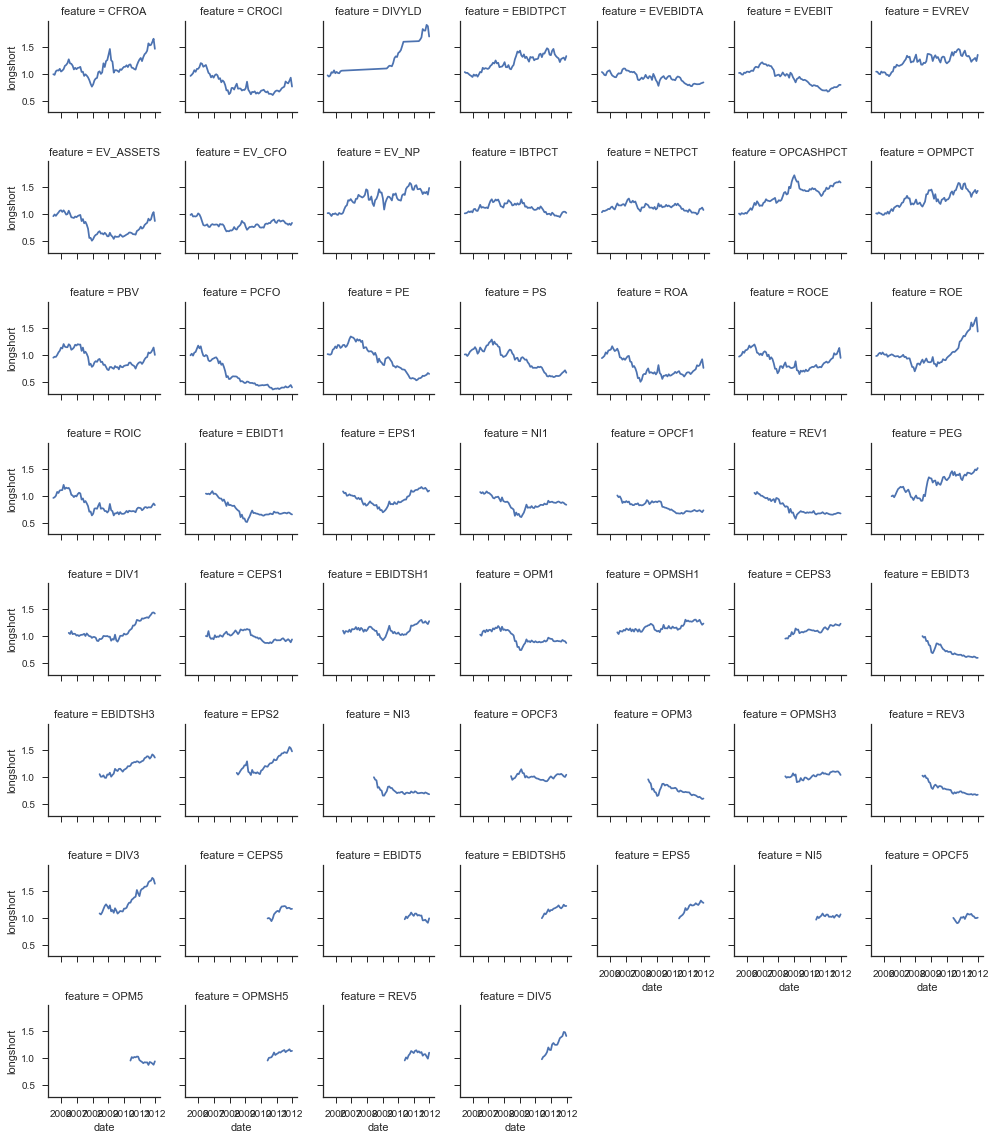

In [136]:
portfolios_melt = portfolios[['longshort','feature']]
portfolios_melt = portfolios_melt.reset_index().rename(columns={'index':'date'})
g = sns.FacetGrid(portfolios_melt, col = 'feature', col_wrap=7, size=2)
g.map(plt.plot,'date','longshort');

In [85]:
#Come back to this a write code for "relation between each feature and 1-month forward 
#return (Figure 40 in paper)
X = X_train[['date','ticker','feature','standalone','consolidated']]
y = y_train[['date','ticker','return']]
important_features = pd.DataFrame(X.feature.unique(),columns = ['feature']).merge(feature_desription, how = 'inner')
important_features = important_features[important_features.priorImportance == 2]
important_features = important_features.reset_index()
#pd.merge(X,y, how ='left')


## Data pre-processing 
like filling missing data, normalizing, uniformizing, sector-neutralizing, quantizing, winsorizing etc to make variations in output variable (returns) more sensitive to variations in input variables and also make combining variables more sensible. 

The paper we are following rigorously analyzed the impact of tranforming the variables and
targets and concluded that uniformizing is the best tranformation in terms out achieving best risk adjusted results. In interest of time, we will not explore other tranformations, and stick to uniformizing X and y. 

Uniformizing X

In [176]:
#Transform X and y

#Let us use uniformization as that is thoroughly concluded as best data tranform in the paper
def uniformize(X,y):
    Xu = X.copy()
    #remove (date,feature) pairs with less than adequate numbers of tickers
    min_tickers_per_date_feature = 75 #Arrived at this by looking at histogram
    ticker_count_by_date_feature = Xu.groupby(['date','feature'])['ticker'].count()
    date_feature_pairs_with_very_few_tickers = ticker_count_by_date_feature[ticker_count_by_date_feature < min_tickers_per_date_feature].index
    Xu = Xu.set_index(['date','feature'])
    Xu = Xu[~Xu.index.isin(date_feature_pairs_with_very_few_tickers)]

    #Lets use consololidated whereever available, else standalone
    Xu['ranker'] = np.where(Xu['consolidated'].isnull(),Xu['standalone'],Xu['consolidated'])
    #drop unwanted columns
    Xu = Xu[['ticker','ranker']]
    #For each (date, feature) pair sort by the ranker value
    Xu = Xu.reset_index()
    Xu = Xu.sort_values(['date','feature','ranker'])
    #Add rank column which is nothing but rank in the sorted order
    Xu['rank'] = Xu.groupby(['date','feature']).cumcount()
    #Add a quantile column that scales rank to [0,1). 
    #This is what is "uniformized" version of X i.e. ranker
    Xu['quantile'] = Xu.groupby(['date','feature'])['rank'].apply(lambda x: x/len(x))
    Xu = Xu[['date','ticker','feature','quantile']]
    yu = y.sort_values(['date','return'])
    yu['rank'] = yu.groupby(['date']).cumcount()
    yu['quantile'] = yu.groupby(['date'])['rank'].apply(lambda x: x/len(x))
    yu = yu[['date','ticker','quantile']]
    return Xu, yu


In [196]:
#Uniformise both X and y
Xu_train, yu_train = uniformize(X_train, y_train)
Xu_test, yu_test = uniformize(X_test, y_test)

In [198]:
#Handpick only features with priorImportance = 2
Xu_train = pd.merge(Xu_train,feature_desription,how = 'left')
Xu_train = Xu_train.loc[Xu_train.priorImportance == 2,['date','ticker','feature','quantile']]

Xu_test = pd.merge(Xu_test,feature_desription,how = 'left')
Xu_test = Xu_test.loc[Xu_test.priorImportance == 2,['date','ticker','feature','quantile']]